In [40]:
%matplotlib inline

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
def get_data():
    dfs = []
    page = 0
    while True:
        new_data = pd.read_json(
            f"https://data.cdc.gov/resource/9mfq-cb36.json?$limit=10000&$offset={10000*page}&$order=created_at"
        )
        if len(new_data):
            dfs.append(new_data)
            page += 1
        else:
            break
    return pd.concat(dfs)

def get_votes():
    return pd.read_csv(
        "./data-resources/StateAbbreviations.csv", index_col="Postalcode"
    ).join(
        pd.read_csv("./data-resources/state-electoral-2016.csv", index_col="State"), on="State"
    )

In [50]:
# data = get_data()
votes = get_votes()

data = data[data.state.isin(votes.index)]

data["state_popn"] = data.state.map(lambda s: votes.loc[s].Pop)
data["test_pos_state_popn"] = 100*data.tot_cases / data.state_popn
data["death_pct_state_popn"] = 100*data.tot_death / data.state_popn

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [104]:
data["political_affiliation"] = data.state.map(lambda s: "D" if votes.loc[s].votesRep < votes.loc[s].votesDem else "R")

In [108]:
STATES = ["MD", "PA", "AL", "TX", "ND"]

In [51]:
len(data)

36480

In [80]:
data.reset_index(inplace=True)

In [126]:
data = data[~pd.isna(data.tot_cases) & data.tot_cases > 0]

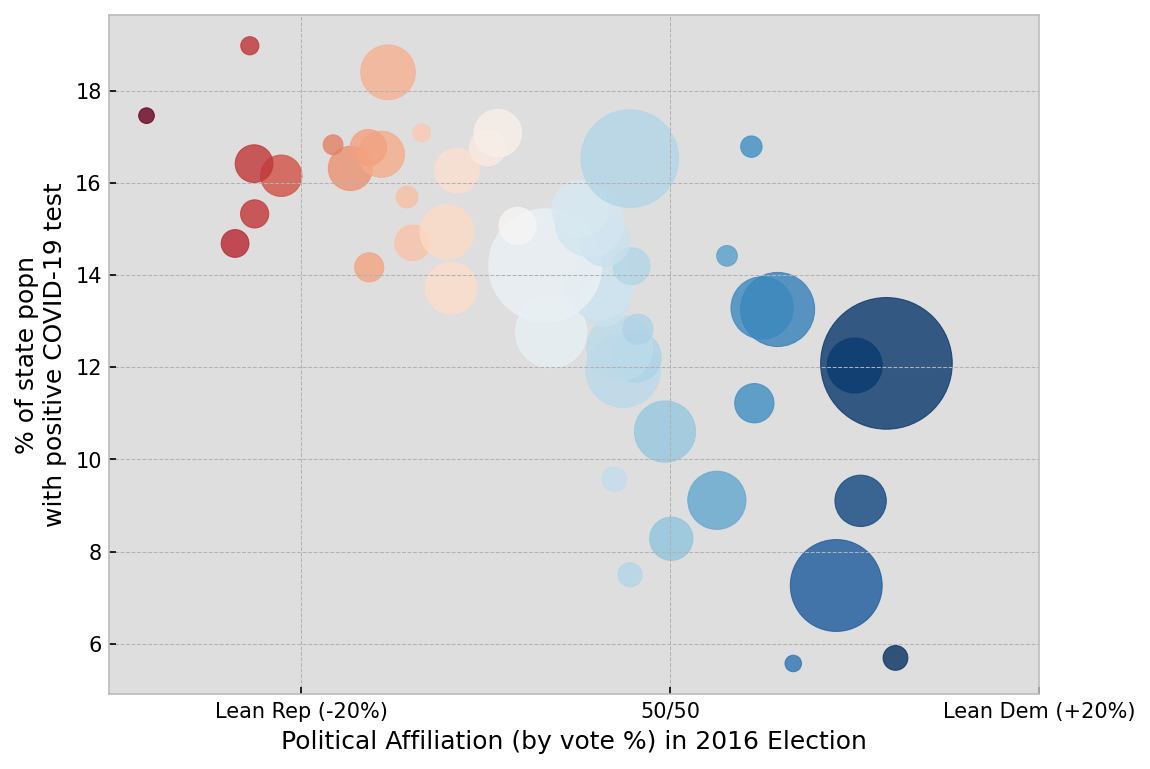

In [158]:
with plt.style.context("bmh"):
    plt.figure(figsize=(8, 6), dpi=150,)
    plt.gca().set_facecolor("#dedede")
    plt.scatter(
        data.groupby("state").test_pos_state_popn.max().sort_values().index.map(lambda x: votes.loc[x].percD),
        data.groupby("state").test_pos_state_popn.max().sort_values(),
        c=data.groupby("state").test_pos_state_popn.max().sort_values().index.map(lambda x: votes.loc[x].percD),
        cmap='RdBu', marker='o', s=[
            data.groupby("state").test_pos_state_popn.max().sort_values().index.map(lambda x: votes.loc[x].Pop)/10000
        ], alpha=0.8
    )
    plt.xlabel("Political Affiliation (by vote %) in 2016 Election")
    plt.ylabel("% of state popn\nwith positive COVID-19 test")
    plt.xticks([30, 50, 70], ["Lean Rep (-20%)", "50/50", "Lean Dem (+20%)"])

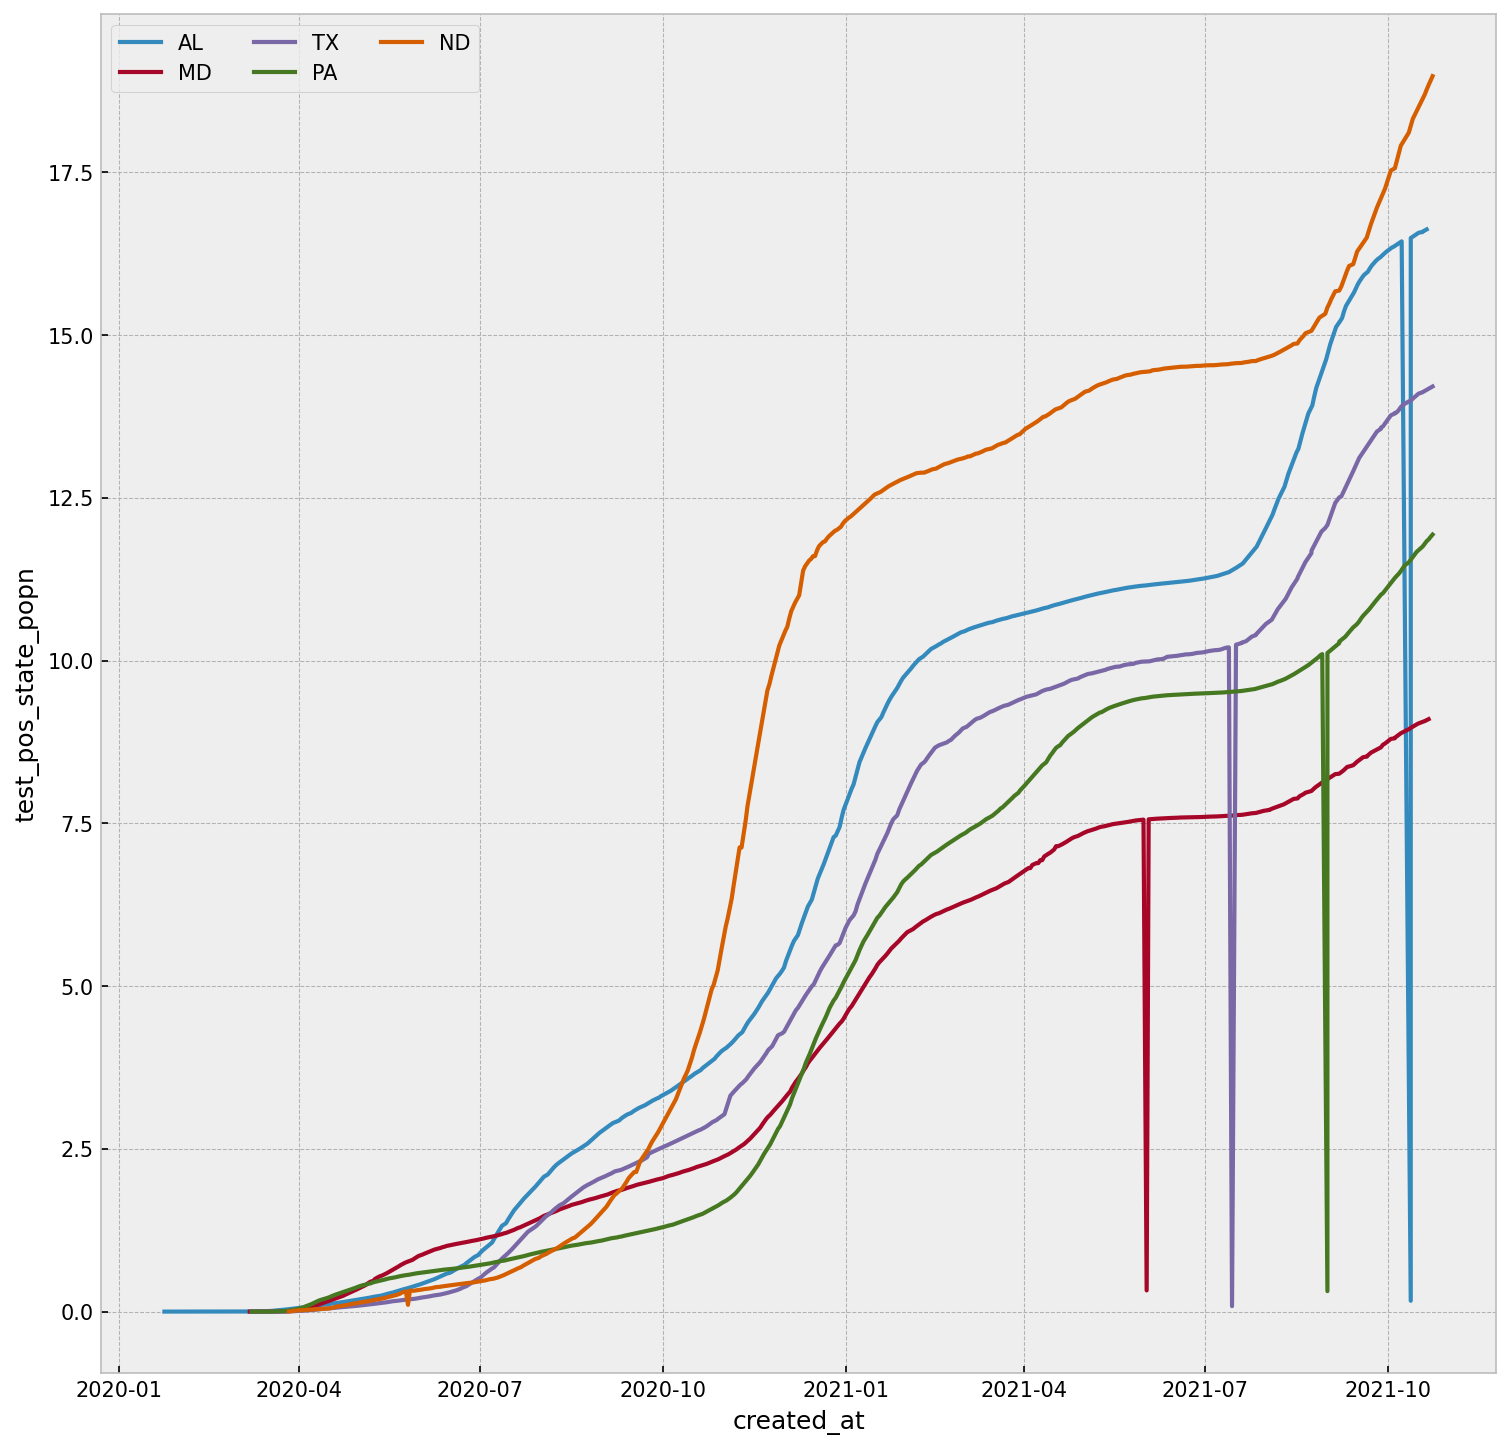

In [147]:
_plotting_data = test[test.state.isin(STATES)]

_plotting_labels = _plotting_data.groupby("state").test_pos_state_popn.max()

with plt.style.context("bmh"):
    plt.figure(figsize=(12, 12), dpi=150)

    sns.lineplot(
        y='test_pos_state_popn',
        x='created_at',
        data=_plotting_data,
        hue='state'
    )
#     plt.yscale("log")
    leg = plt.legend(ncol=3)

In [191]:
data.groupby(data.created_at.dt.day)

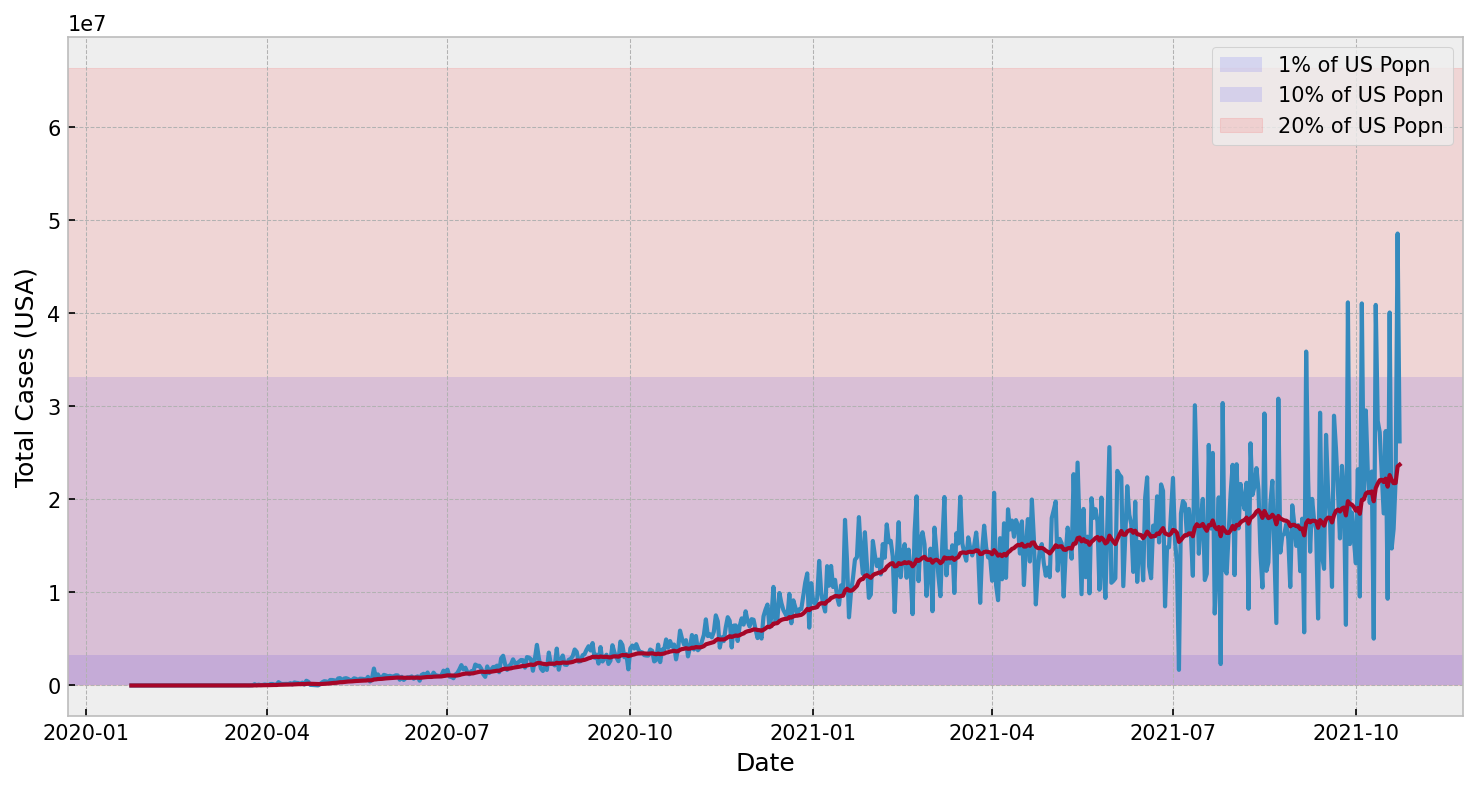

In [227]:
_d = data.groupby(data.created_at.dt.date).sum()

POPN_ESTIMATE = 332_000_000

with plt.style.context("bmh"):
    plt.figure(figsize=(12, 6), dpi=150)
    sns.lineplot(x='created_at', y=_d.tot_cases, data=_d, )
    sns.lineplot(x='created_at', y=_d.tot_cases.ewm(14).mean(), data=_d)
    plt.xlabel("Date")
    plt.ylabel("Total Cases (USA)")
    
    plt.axhspan(0, POPN_ESTIMATE*0.01, alpha=0.1, label="1% of US Popn")
    plt.axhspan(0, POPN_ESTIMATE*0.1, alpha=0.1, label="10% of US Popn")
    plt.axhspan(0, POPN_ESTIMATE*0.2, alpha=0.1, color='r', label="20% of US Popn")
    plt.legend()
#     plt.yscale("log")